In [1]:
#import all required packages
import os
import numpy as np
import re
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.visualization import SqrtStretch, simple_norm
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.io import fits,ascii
from astropy.wcs import WCS
from astropy import units as u
from astropy.stats import sigma_clipped_stats
from astropy.table import join, vstack, Table
from astropy.coordinates import SkyCoord, search_around_sky, Angle

from photutils.aperture import SkyCircularAperture,SkyCircularAnnulus,aperture_photometry 
from photutils.segmentation import detect_threshold, detect_sources, deblend_sources, SourceCatalog
from photutils.background import Background2D, MedianBackground, SExtractorBackground, MMMBackground
from photutils.utils import calc_total_error

In [2]:
#new functions needed for this notebook
from astropy.coordinates.matching import _get_cartesian_kdtree

from regions import read_ds9, write_ds9, CircleSkyRegion

In [3]:
#import configuration for selected file
from config import wavelength, segdetsig, finddetsig, bkgbox #import additional common paramters
from config import dpath, dpathalt, ds9path #import additional common paramters

from config import *

In [4]:
#change directory to where data is
try:
    os.chdir(dpath)
except:
    os.chdir(dpathalt)

In [5]:
#pick a field to start with so we can get the table structure. 
#The files for the field cannot be empty or an error message will display
startfield=FieldA.name

if os.path.exists(startfield+'_25um_CombCat.fits'):
    mastercat25=Table.read(startfield+'_25um_CombCat.fits')
    
    #fix for issue with combining tables with objects as columns
    mastercat25['RA(J2000)']=mastercat25['sky_centroid'].ra
    mastercat25['DEC(J2000)']=mastercat25['sky_centroid'].dec
    mastercat25.remove_column('sky_centroid')

else:
    print('Error... Must pick another file to start with')


In [6]:
#loop through all the saved photometry tables for individual fields and append them together
for info in field._registry:
    filename=info.filename
    name=info.name
    
    #print('\nLoading in photometry data from field: ', name)
    
    if name is not startfield:
        
        if os.path.exists(name+'_25um_CombCat.fits'):
            newtab1=Table.read(name+'_25um_CombCat.fits')
            
            #fix for issue with combining tables with objects as columns
            newtab1['RA(J2000)']=newtab1['sky_centroid'].ra
            newtab1['DEC(J2000)']=newtab1['sky_centroid'].dec
            newtab1.remove_column('sky_centroid')
            
            #combine tables
            mastercat25=vstack([mastercat25,newtab1])

#re-add "sky_centroid" column 
mastercat25['sky_centroid']=SkyCoord(mastercat25['RA(J2000)'],mastercat25['DEC(J2000)'],unit=u.deg)

#print the table sizes to get source counts
print('Raw number of combinded sources: ', len(mastercat25))

Raw number of combinded sources:  1783


In [7]:
#rename field based id to anothter name to avoid confusion
mastercat25.rename_column('id', 'old_id')

#add new ids to the master catalog ahead of quality cuts
mastercat25['id_init']=np.linspace(1,len(mastercat25),len(mastercat25),dtype=np.int)

#print the master catalog
mastercat25

C:\Users\MHANKI~1\AppData\Local\Temp/ipykernel_2620/59686400.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mastercat25['id_init']=np.linspace(1,len(mastercat25),len(mastercat25),dtype=np.int)


type,old_id,xcenter,ycenter,sky_center,aperture_sum_4pix,aperture_sum_err_4pix,aperture_sum_7pix,aperture_sum_err_7pix,aperture_sum_12pix,aperture_sum_err_12pix,pixAnnArea,ann_bkg_med,ann_bkg_mean,ann_bkg_std,texp_med,texp_mean,aper_sum_bkgsub_4pix,aper_snr_4pix,aper_area_4pix,aper_sum_bkgsub_7pix,aper_snr_7pix,aper_area_7pix,aper_sum_bkgsub_12pix,aper_snr_12pix,aper_area_12pix,Field,wv,RA(J2000),DEC(J2000),sky_centroid,id_init
,,pix,pix,"deg,deg",,,,,,,,,,,,,,,,,,,,,,,,deg,deg,"deg,deg",
bytes1,int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes7,int32,float64,float64,object,int32
C,1,186.13215812089783,44.83908685070949,"266.3254722621009,-29.07789334142956",4.251441381840274,0.08140057006109706,7.009887388867945,0.1414690116539936,9.333651826471463,0.24034146855993158,842.3889699154489,0.00015792294881538803,0.00037795126751484764,0.005781510100510126,363.0956726074219,326.0785093413304,4.243126847454111,75.65767425773959,52.64931061971556,6.984424127310321,124.05814677265663,161.23851377287892,9.258821016995999,160.89590869049604,473.84379557743995,FieldA,25,266.3254722621009,-29.07789334142956,"266.3254722621009,-29.07789334142956",1
C,2,91.13388232439642,221.0476097606492,"266.34865390850393,-29.040300695372114",1.3087028693588476,0.06457617602575318,2.1016104813737044,0.11298118086528029,2.570591187679788,0.19357004533413544,842.3889699154489,0.00011159306027058632,0.0005865174569878199,0.0052890662534054115,477.7574157714844,475.80978975703977,1.3028275716656568,19.176781006656906,52.64931061971556,2.083617382188308,29.63774817430125,161.23851377287892,2.5177135084410716,30.19705170464805,473.84379557743995,FieldA,25,266.34865390850393,-29.040300695372114,"266.34865390850393,-29.040300695372114",2
C,3,214.3263472674334,138.54481158630034,"266.31859196098685,-29.057902466534006",4.517279878238537,0.06429089590388001,9.700689650183616,0.11249368591449324,18.396979270647673,0.1928197424831015,842.3889699154489,0.005476475752424609,0.007393471952174815,0.010939288794574635,477.7574157714844,476.6207881826312,4.228947205247794,70.1773179717275,52.64931061971556,8.817670839149462,150.50326768165246,161.23851377287892,15.80198521373098,271.30942864767303,473.84379557743995,FieldA,25,266.31859196098685,-29.057902466534006,"266.31859196098685,-29.057902466534006",3
C,4,212.7142389276733,141.23325791893993,"266.31898545191007,-29.05732895919832",4.577030147285304,0.06426838656977268,10.718344604081759,0.11245133486776629,21.375549586640382,0.1926839507467687,842.3889699154489,0.006605751189177805,0.00894511909769135,0.011903154200365071,477.7574157714844,475.7045142320095,4.2292419010497255,69.01698575128042,52.64931061971556,9.653243099985302,164.90305656388173,161.23851377287892,18.245455370520183,315.52690022699494,473.84379557743995,FieldA,25,266.31898545191007,-29.05732895919832,"266.31898545191007,-29.05732895919832",4
C,5,208.6319409033432,157.28357758668136,"266.31998201863314,-29.05390495647942",8.761508922127174,0.0642364378465394,22.78083532228061,0.11241803572221779,43.08542487402444,0.1926180723563314,842.3889699154489,0.00772719273513307,0.011328467887221014,0.01467723523285137,477.7574157714844,475.60596309923363,8.354677551596744,146.12537611822236,52.64931061971556,21.534914250031168,386.67245236362214,161.23851377287892,39.42394253925057,709.8989212327396,473.84379557743995,FieldA,25,266.31998201863314,-29.05390495647942,"266.31998201863314,-29.05390495647942",5
C,6,212.0622251554071,161.08242277174958,"266.31914495440424,-29.05309448168491",7.501255169169433,0.0643800179750148,20.44725753010384,0.11262472627650104,43.040572984728094,0.193004944319555,842.3889699154489,0.009196170754891108,0.012972813296279445,0.015832963666569794,477.7574157714844,476.00238638121897,7.017083118583227,119.11340899958353,52.64931061971556,18.964480625183583,336.6562630851338,161.2

In [8]:
#Optional - write 'master' catalogs to fits prior to quality cuts
#mastercat25.write('masterCatComb_FromFields_25um_NoCuts.fits',overwrite=True)

In [9]:
def makeDS9file(savename, table, radius, color='green', labelon=False,label='ColumnName'):
    scs=table['sky_centroid']
    
    decimals = 1 # number of decimal places to display with labels
    
    #loop through and create region instances for each source
    regions=[]
    for i in range(0,len(scs)):
        region = CircleSkyRegion(scs[i], radius)
        regions.append(region)
            #write out region file
    write_ds9(regions, savename)
    
    hld=""
    with open(savename, 'r+') as f:
        lineno=0
        for line in f:
            if lineno<len(table):
                if labelon:
                    text=line.replace(r')', r') # color='+color+' text={'+str(np.round(table[label][lineno-2],decimals))+'}')
                else:
                    text=line.replace(r')', r') # color='+color)
                hld=hld+text
                lineno=lineno+1
        f.seek(0)
        f.write(hld)
        f.truncate()

In [10]:
#write out save ds9 region files  - Optional for inspection
#set size of regions 
r = Angle(0.00083333, u.deg) #must be in degrees - current value is r=3"
#write out ds9 files
makeDS9file('mastercatComb_25um_labelIDinit.reg', mastercat25, r, color='yellow', labelon=True, label="id_init")
makeDS9file('mastercatComb_25um_label4pixSNR.reg', mastercat25, r, color='cyan', labelon=True, label="aper_snr_4pix")

In [11]:
#source coords should be skycoord objects, sep should be an angular quantity e.g., 4*u.arcsec
def remove_duplicates(cat, sep):
	sourcecoords=cat['sky_centroid']

	#create KD Tree
	kdt=_get_cartesian_kdtree(sourcecoords)
    
	#search radius
	r = (2 * np.sin(Angle(sep) / 2.0)).value #search radius
    
	#initialize counter
	counter=0
    
	#create array to hold matches
	matchstore=np.zeros(len(cat),dtype=np.int)
    
	#loop through and find all matching sources within crossmatch radius
	for i, matches in enumerate(kdt.query_ball_tree(kdt,r)):
		if len(matches)>1:
			counter+=1
			
			for match in matches:
				if match!=matches[(match+1)%len(matches)]:
					matchstore[match]=matches[(match+1)%len(matches)]+1
				else:
					matchstore[match]=matches[(match+2)%len(matches)]+1

	#store possible crossmatches
	cat['selfXmatch']=matchstore
	print('number of likely duplicates: ', counter)
    
	#create keep and remove lists
	keep=[]
	remove=[]
    
	#loop through and mark sources to keep and remove based on which has the greater aperture photometry snr
	for row in cat:
		if row['selfXmatch']>0:
			#print(row['Master_id'])
			idx1 = row['id_init']
			idx2 = row['selfXmatch']
			
			row1=cat[cat['id_init']==idx1]
			row2=cat[cat['id_init']==idx2]
			
			snr1=row1['aper_snr_4pix'].data[0]
			snr2=row2['aper_snr_4pix'].data[0]
			           
			if snr1>snr2:
				keep.append(idx1)
				remove.append(idx2)
			else:
				keep.append(idx2)
				remove.append(idx1)

	#remove duplicates in lists
	keep=list(set(keep))
	remove=list(set(remove))
    
	#remove duplicates in table
	removeIdx=np.array(remove)-1 #fix zero/one initialization issue
	cat.remove_rows(removeIdx)
	
	return cat

In [12]:
#Now lets look at possible duplications that may exist because of overlapping data coverage

print('Number of sources with duplicates included', len(mastercat25))

mastercat25=remove_duplicates(mastercat25, 3.0*u.arcsec)

print('Number of sources with duplicates removed', len(mastercat25))

Number of sources with duplicates included 1783
number of likely duplicates:  375


C:\Users\MHANKI~1\AppData\Local\Temp/ipykernel_2620/3399744466.py:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  matchstore=np.zeros(len(cat),dtype=np.int)


Number of sources with duplicates removed 1586


In [13]:
#write 'master' catalogs to fits - optional for testing
#mastercat25.write('masterCat_FromFields_noDuplicates_25um.fits',overwrite=True)

In [14]:
#write out save ds9 region files - optional for testing
makeDS9file('mastercat_noDuplicates_25um_labelID.reg', mastercat25, r, color='magenta', labelon=True, label="id_init")

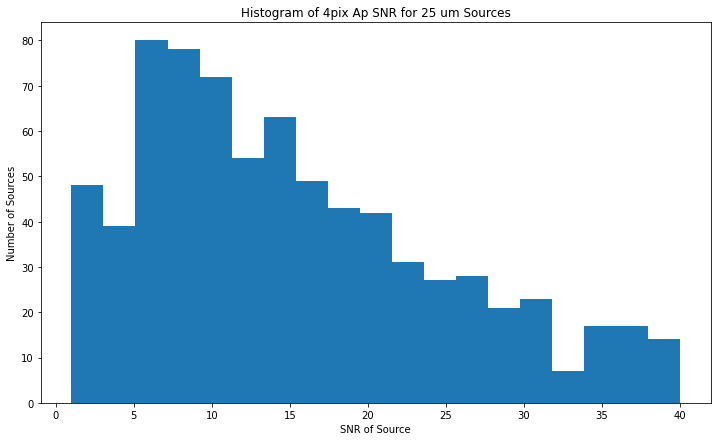

In [15]:
#now lets look at SNR distrobution
binlist=np.linspace(1,40,20)

plt.figure(figsize=(12,7))
plt.title('Histogram of 4pix Ap SNR for 25 um Sources')
plt.hist(mastercat25['aper_snr_4pix'],bins=binlist)
plt.xlabel('SNR of Source')
plt.ylabel('Number of Sources')
#plt.xlim(0,25)
plt.show()


In [16]:
#lets examine SNR cuts...
snrcut4pix=mastercat25['aper_snr_4pix']>=5.0 #max snr in all computed apertures must be gtreq to 5
mcat25snrcut=mastercat25[snrcut4pix] #apply snr cut

print("Number of Catalog Sources after SNR cut: ", len(mcat25snrcut))

Number of Catalog Sources after SNR cut:  973


In [17]:
#other cuts to consider????

In [18]:
makeDS9file('mastercatComb_4pixSNRselect_25m_NoLabel.reg', mcat25snrcut, r, color='green')

## Repeat process for 37 um data

In [19]:
#pick a field to start with so we can get the table structure. 
#The files for the field cannot be empty or an error message will display
startfield=FieldA.name

if os.path.exists(startfield+'_37um_CombCat.fits'):
    mastercat37=Table.read(startfield+'_37um_CombCat.fits')
    
    #fix for issue with combining tables with objects as columns
    mastercat37['RA(J2000)']=mastercat37['sky_centroid'].ra
    mastercat37['DEC(J2000)']=mastercat37['sky_centroid'].dec
    mastercat37.remove_column('sky_centroid')

else:
    print('Error... Must pick another file to start with')

In [20]:
#loop through all the saved photometry tables for individual fields and append them together
for info in field._registry:
    filename=info.filename
    name=info.name
    
    #print('\nLoading in photometry data from field: ', name)
    
    if name is not startfield:
        
        if os.path.exists(name+'_37um_CombCat.fits'):
            newtab1=Table.read(name+'_37um_CombCat.fits')
            
            #fix for issue with combining tables with objects as columns
            newtab1['RA(J2000)']=newtab1['sky_centroid'].ra
            newtab1['DEC(J2000)']=newtab1['sky_centroid'].dec
            newtab1.remove_column('sky_centroid')
            
            #combine tables
            mastercat37=vstack([mastercat37,newtab1])

#re-add "sky_centroid" column 
mastercat37['sky_centroid']=SkyCoord(mastercat37['RA(J2000)'],mastercat37['DEC(J2000)'],unit=u.deg)

#print the table sizes to get source counts
print('Raw number of combinded 37um sources: ', len(mastercat37))

Raw number of combinded 37um sources:  1701


In [21]:
#rename field based id to anothter name to avoid confusion
mastercat37.rename_column('id', 'old_id')

#add new ids to the master catalog ahead of quality cuts
mastercat37['id_init']=np.linspace(1,len(mastercat37),len(mastercat37),dtype=np.int)

#print the master catalog
mastercat37

C:\Users\MHANKI~1\AppData\Local\Temp/ipykernel_2620/1604376380.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mastercat37['id_init']=np.linspace(1,len(mastercat37),len(mastercat37),dtype=np.int)


type,old_id,xcenter,ycenter,sky_center,aperture_sum_4pix,aperture_sum_err_4pix,aperture_sum_7pix,aperture_sum_err_7pix,aperture_sum_12pix,aperture_sum_err_12pix,pixAnnArea,ann_bkg_med,ann_bkg_mean,ann_bkg_std,texp_med,texp_mean,aper_sum_bkgsub_4pix,aper_snr_4pix,aper_area_4pix,aper_sum_bkgsub_7pix,aper_snr_7pix,aper_area_7pix,aper_sum_bkgsub_12pix,aper_snr_12pix,aper_area_12pix,Field,wv,RA(J2000),DEC(J2000),sky_centroid,id_init
,,pix,pix,"deg,deg",,,,,,,,,,,,,,,,,,,,,,,,deg,deg,"deg,deg",
bytes1,int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes7,int32,float64,float64,object,int32
C,1,142.4222167812415,244.69398363028392,"266.33571101881336,-29.03729396282822",16.823313759787407,0.13052538734462685,38.275534963104235,0.2283676991062819,68.07677396548733,0.39151472058742304,842.3887129996068,0.016057226720894983,0.019351436261361116,0.020377260213605218,400.12127685546875,398.9379262555463,15.977912100302554,271.5398303385732,52.64929456247541,35.686492380931874,612.0870483772352,161.238464597581,60.46815903012367,1036.7759983151554,473.8436510622788,FieldA,37,266.33571101881336,-29.03729396282822,"266.33571101881336,-29.03729396282822",1
C,2,143.5452530013948,244.50410045870763,"266.33543699669957,-29.037334485899724",16.76676079088167,0.13054563467289776,37.57966399928746,0.22840555953571776,67.17481107905367,0.391592620955339,842.3887129996068,0.016504211012411327,0.020389312693609014,0.021973153005091846,400.12127685546875,399.39843961883486,15.897825723767975,269.07228308078123,52.64929456247541,34.91855035625177,597.0277710914795,161.238464597581,59.35439547503041,1014.5156440506069,473.8436510622788,FieldA,37,266.33543699669957,-29.037334485899724,"266.33543699669957,-29.037334485899724",2
C,3,185.8843184824861,53.32524497654224,"266.325104824915,-29.07811945352745",3.2922456491385277,0.1288646792540781,5.946337621550762,0.22777968022304018,9.70170351559762,0.4130127488866621,842.3887129996068,0.0012552982252203642,0.0022844224406179886,0.009843589123761744,400.12127685546875,398.4387799392621,3.226155083115148,49.575878874489725,52.64929456247541,5.743935263104162,88.59866122176086,161.238464597581,9.106888421387204,137.98415905490256,473.8436510622788,FieldA,37,266.325104824915,-29.07811945352745,"266.325104824915,-29.07811945352745",3
C,4,213.49728794963903,148.54816508325013,"266.31836645961846,-29.057804902179896",6.494607739758986,0.13310729707661068,14.312205185063284,0.23286900430662769,25.933423437623027,0.3990069575609686,842.3887129996068,0.004691032885682408,0.007080396648139035,0.015030417264407871,400.12127685546875,399.3883021741741,6.2476281675584335,100.29052696171526,52.64929456247541,13.555830245199093,223.54164787238813,161.238464597581,23.710607287818057,391.79407109255396,473.8436510622788,FieldA,37,266.31836645961846,-29.057804902179896,"266.31836645961846,-29.057804902179896",4
C,5,212.18811637382836,150.4513954114122,"266.3186860037761,-29.05739890297304",6.54538637221277,0.13306405204379268,14.877321306298306,0.232778276627887,28.09258049300846,0.39882551009772577,842.3887129996068,0.005485694207867119,0.00901293769265498,0.01733913996203883,400.12127685546875,398.3890928989456,6.256568441983109,98.05896050842077,52.64929456247541,13.992816394969969,227.84673284334434,161.238464597581,25.49321912094151,418.12371003261825,473.8436510622788,FieldA,37,266.3186860037761,-29.05739890297304,"266.3186860037761,-29.05739890297304",5
D,6,157.19979139396133,43.41438316546808,"266.3321068013122,-29.08023375689039",0.14400016195680396,0.16239107832519056,0.16686060634235192,0.2814870766390917,0.9955628416209896,0.4801389625938168,842.3887129996068,-8.000353119281957e-05,6.820277413683625e-05,0.009151644911150131,305.60818724626745,281.07173697725005,0.1482122914366129,0.23837376013079437,52.64929456247541,0.1797602528742668,0.20081879545710157,161.2384645975

In [22]:
#Optional - write 'master' catalogs to fits prior to quality cuts
#mastercat25.write('masterCatComb_FromFields_25um_NoCuts.fits',overwrite=True)

#write out save ds9 region files  - Optional for inspection

#set size of regions 
r = Angle(0.00083333, u.deg) #must be in degrees - current value is r=3"
#write out ds9 files
makeDS9file('mastercatComb_37um_labelIDinit.reg', mastercat37, r, color='yellow', labelon=True, label="id_init")
makeDS9file('mastercatComb_37um_label4pixSNR.reg', mastercat37, r, color='cyan', labelon=True, label="aper_snr_4pix")

In [23]:
#Now lets look at possible duplications that may exist because of overlapping data coverage

print('Number of sources with duplicates included', len(mastercat37))

mastercat37=remove_duplicates(mastercat37, 3.0*u.arcsec)

print('Number of sources with duplicates removed', len(mastercat37))

Number of sources with duplicates included 1701
number of likely duplicates:  367


C:\Users\MHANKI~1\AppData\Local\Temp/ipykernel_2620/3399744466.py:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  matchstore=np.zeros(len(cat),dtype=np.int)


Number of sources with duplicates removed 1508


In [24]:
#write 'master' catalogs to fits - optional for testing
#mastercat37.write('masterCat_FromFields_noDuplicates_37um.fits',overwrite=True)

In [25]:
#write out save ds9 region files - optional for testing
makeDS9file('mastercat_noDuplicates_37um_labelID.reg', mastercat37, r, color='magenta', labelon=True, label="id_init")

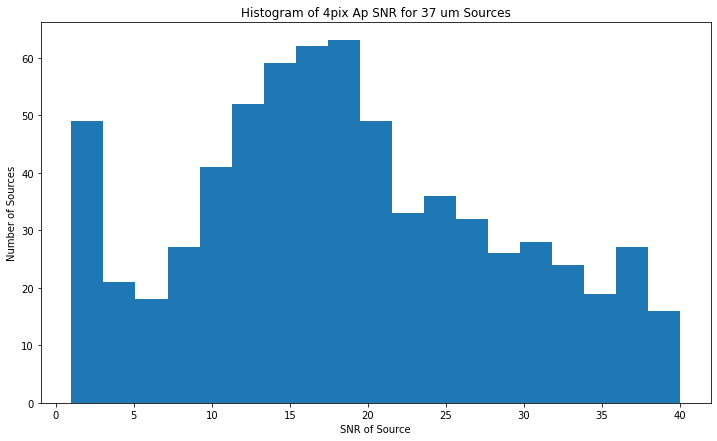

In [26]:
#now lets look at SNR distrobution
binlist=np.linspace(1,40,20)

plt.figure(figsize=(12,7))
plt.title('Histogram of 4pix Ap SNR for 37 um Sources')
plt.hist(mastercat37['aper_snr_4pix'],bins=binlist)
plt.xlabel('SNR of Source')
plt.ylabel('Number of Sources')
#plt.xlim(0,25)
plt.show()


In [27]:
#lets examine SNR cuts...
snrcut4pix=mastercat37['aper_snr_4pix']>=5.0 #max snr in all computed apertures must be gtreq to 5
mcat37snrcut=mastercat37[snrcut4pix] #apply snr cut

print("Number of Catalog Sources after SNR cut: ", len(mcat37snrcut))

Number of Catalog Sources after SNR cut:  1029


In [28]:
#more cuts to consider?

In [29]:
makeDS9file('mastercatComb_4pixSNRselect_37m_NoLabel.reg', mcat37snrcut, r, color='green')

# Crossmatch the 25 and 37 um catalogs

In [30]:
#get source coordinates from both tables
sources25=mcat25snrcut['sky_centroid']
sources37=mcat37snrcut['sky_centroid']

#crossmatch source lists to look for duplication
idx,rdx, d2d, d3d = sources25.search_around_sky(sources37, 3*u.arcsec) #use larger search radius?
print('Number of crossmatched 25/37 sources found: ', len(idx))

Number of crossmatched 25/37 sources found:  604


In [31]:
matched25=mcat25snrcut[rdx]
matched37=mcat37snrcut[idx]

In [32]:
#find the 'not' indcies for sources in table
def findNOTindex(tab,index):
    allpos=np.linspace(0,len(tab)-1,len(tab),dtype=np.int64) 
    notindex=list(set(allpos)-set(index))
    return notindex

In [33]:
notrdx=findNOTindex(mcat25snrcut,rdx)
only25=mcat25snrcut[notrdx]

notidx=findNOTindex(mcat37snrcut,idx)
only37=mcat37snrcut[notidx]

In [40]:
t1=Table()
t1['RA(J2000)']=matched25['RA(J2000)']
t1['DEC(J2000)']=matched25['DEC(J2000)']
t1['25um Flux (Jy)']=matched25['aper_sum_bkgsub_4pix']
t1['25um SNR']=matched25['aper_snr_4pix']
t1['37um Flux (Jy)']=matched37['aper_sum_bkgsub_4pix']
t1['37um SNR']=matched37['aper_snr_4pix']

t2=Table()
t2['RA(J2000)']=only25['RA(J2000)']
t2['DEC(J2000)']=only25['DEC(J2000)']
t2['25um Flux (Jy)']=only25['aper_sum_bkgsub_4pix']
t2['25um SNR']=only25['aper_snr_4pix']
t2['37um Flux (Jy)']=-1
t2['37um SNR']=-1

t3=Table()
t3['RA(J2000)']=only37['RA(J2000)']
t3['DEC(J2000)']=only37['DEC(J2000)']
t3['25um Flux (Jy)']=-1
t3['25um SNR']=-1
t3['37um Flux (Jy)']=only37['aper_sum_bkgsub_4pix']
t3['37um SNR']=only37['aper_snr_4pix']

In [41]:
mastercat=vstack((t1,t2,t3))

In [42]:
#change format of columns to save fewer decimal places
for col in mastercat.colnames:
    if col!='RA(J2000)' and col!='DEC(J2000)' and col!='type': #skip columns that aren't relevant
        mastercat[col].info.format = '%.4G'

#display catalog
mastercat

RA(J2000),DEC(J2000),25um Flux (Jy),25um SNR,37um Flux (Jy),37um SNR
deg,deg,,,,
float64,float64,float64,float64,float64,float64
266.33591716284303,-29.037906320021353,19.06,348.9,15.98,271.5
266.3254722621009,-29.07789334142956,4.243,75.66,3.226,49.58
266.31859196098685,-29.057902466534006,4.229,70.18,6.248,100.3
266.31998201863314,-29.05390495647942,8.355,146.1,8.052,130.6
266.3362279098425,-29.038785430975665,12.45,226.6,11.1,184.4
266.33448072434913,-29.038787791948685,8.867,160,10.02,164.6
266.35377268616793,-29.055963810072285,1.6,19.96,1.126,9.995
266.3549333829732,-29.054051210496706,1.783,24.06,0.9815,6.991


In [43]:
#Optional - write 'master' catalogs to fits prior to quality cuts
mastercat.write('masterCat_step3_final.fits',overwrite=True)

## testing...

In [37]:
tab25=Table.read('FieldA_25um_CombCat.fits')
#tab25

In [38]:
tab37=Table.read('FieldA_37um_CombCat.fits')
#tab37

In [ ]:
keepcols=['RA(J2000)', 'DEC(J2000)','aper_sum_bkgsub_4pix','aper_snr_4pix','aper_sum_bkgsub_7pix','aper_snr_7pix',
          'aper_sum_bkgsub_12pix','aper_snr_12pix','type']
fincat=mastercat[keepcols]

#change format of columns to save fewer decimal places
for col in fincat.colnames:
    if col!='RA(J2000)' and col!='DEC(J2000)' and col!='type': #skip columns that aren't relevant
        fincat[col].info.format = '%.4G'

#display catalog
fincat